In [1]:
import sys
# sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
from torch.nn import parameter

from fracturbulence.common import *
from fracturbulence.Calibration import CalibrationProblem
from fracturbulence.DataGenerator import OnePointSpectraDataGenerator

from pathlib import Path

savedir = Path().resolve() / "data" / "results" 

In [2]:
import fracturbulence as ft

In [3]:
spectra = np.genfromtxt("../script/Spectra.dat", delimiter=',')


In [4]:
####################################
### Configuration
####################################

config = {
    'type_EddyLifetime' :   'tauNet',  ### 'const', TwoThird', 'Mann', 'tauNet'
    'type_PowerSpectra' :   'RDT', ### 'RDT', 'zetaNet', 'C3Net', 'Corrector'
    'nlayers'           :   2,
    'hidden_layer_size' :   10,
    'learn_nu'          :   True, ### NOTE: Experiment 1: False, Experiment 2: True
    'plt_tau'           :   True,
    'tol'               :   1.e-3, ### not important
    'lr'                :   1,     ### learning rate
    'penalty'           :   1,  #originally: 1.e-1,
    'regularization'    :   1.e-2,
    'nepochs'           :   2,
    'curves'            :   [0,1,2,3],
    'data_type'         :   'Custom', ### 'Kaimal', 'SimiuScanlan', 'SimiuYeo', 'iso'
    'spectra_file'       :   '../script/Spectra.dat',
    'Uref'              :   10, # m/s
    'zref'              :   1, #m
    'domain'            :   torch.logspace(-2, 2, 20), ### NOTE: Experiment 1: np.logspace(-1, 2, 20), Experiment 2: np.logspace(-2, 2, 40)
    'noisy_data'        :   7.e-2, # 0*3.e-1, ### level of the data noise  ### NOTE: Experiment 1: zero, Experiment 2: non-zero
    'output_folder'     :   savedir,
    'input_folder'      :   '../script/'
}
pb = CalibrationProblem(**config)

['relu', 'relu']


/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
####################################
#Calculating turbulence parameters according to IEC standards
# we assume a hub height z=150m corresponding to the IEA 15MW wind turbine hub height
zref=config['zref']; # Hub height in meters
Uref=config['Uref']; # Average Hub height velocity in m/s
Iref = 0.14
sigma1=Iref*(0.75*Uref+5.6)
Lambda1=42; # Longitudinal turbulence scale parameter at hub height


#Mann model parameters
#Gamma = 3.9
#sigma = 0.55*sigma1
#L=0.8*Lambda1;


z0=0.01
ustar=0.41*Uref/log(zref/z0)

L     = 14.09
Gamma = 3.9
sigma = 0.15174254

print(L,Gamma,sigma)

parameters = pb.parameters
parameters[:3] = [log(L), log(Gamma), log(sigma)] #All of these parameters are positive 
#so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = config['domain'] #np.logspace(-1, 2, 20)


if(config['data_type']=='Custom'):
    if config['spectra_file'] is not None:
        spectra_file=config['spectra_file']
        print('Reading file' + spectra_file + '\n')
        CustomData=np.genfromtxt(spectra_file,skip_header=1,delimiter=',')
        f=CustomData[:,0]
        k1_data_pts=2*np.pi*f/Uref

DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **config).Data

### Data perturbation
data_noise_magnitude = config['noisy_data']
if data_noise_magnitude:
    Data[1][:] *= np.exp(np.random.normal(loc=0, scale=data_noise_magnitude, size=Data[1].shape))

DataValues = Data[1]

14.09 3.9 0.15174254
Reading file../script/Spectra.dat

Reading file ../script/Spectra.dat

DataValues is on -1


In [6]:
type(k1_data_pts)

numpy.ndarray

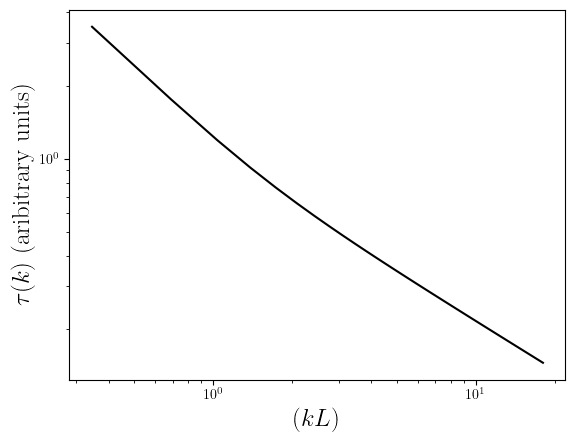

In [7]:
IECtau=MannEddyLifetime(k1_data_pts*L)
plt.figure(1)
plt.loglog(k1_data_pts*L,IECtau,'k')
#plt.xlim(0.1,60)
plt.ylabel(r'$\tau(k)$ (aribitrary units)',fontsize=18)
plt.xlabel(r'$(kL)$',fontsize=18)
plt.show()
#plt.savefig('tau.png')

In [8]:
plt.rc('text',usetex=True)
plt.rc('font',family='serif')


kF = pb.eval(k1_data_pts)
plt.figure(1,figsize=(10,10))
clr=['black','blue','red']
plt.figure(1)
for i in range(3):
    plt.plot(k1_data_pts, kF[i], '-', color=clr[i], label=r'$F_{0:d}$ model'.format(i+1))
    plt.plot(k1_data_pts, DataValues[:,i,i], '--',color=clr[i],label=r'$F_{0:d}$ data'.format(i+1) )#, label=r'$F_{0:d}$ data'.format(i+1))
plt.plot(k1_data_pts, -kF[3], '-m', label=r'-$F_{13}$ model')
plt.plot(k1_data_pts, -DataValues[:,0,2], '--m', label=r'$-F_{13}$ data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k_1$',fontsize=22)
#plt.xlim(0.01,2)
#plt.ylim(0.00001,0.1)
plt.ylabel(r'$k_1 F(k_1)/u_\ast^2$',fontsize=22)
plt.legend(loc='lower left',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(which='both')
plt.title("Initial Guess")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'clone'


Callibrating MannNet...
Initial loss:  1.653980208845049

-> Epoch 0

pen =  0.0031851430368418023
reg =  0.0004349448789579711
loss  =  1.6576002967608487
-> nu =  -0.3333333432674408
pen =  0.0042178706065537875
reg =  0.0004347339726847125
loss  =  0.4874780514961895
-> nu =  -0.33185198266569016
pen =  0.003530876774041587
reg =  0.0004350022437876562
loss  =  0.41423943583895545
-> nu =  -0.3307235963231372
pen =  0.00260989545621355
reg =  0.000435395262176864
loss  =  0.38355182707981406
-> nu =  -0.32856173803436906
pen =  0.00026780064028461754
reg =  0.00043691678004498317
loss  =  0.31506315512975275
-> nu =  -0.31966984178060476
pen =  1.4209862070657512e-05
reg =  0.0004380047551019008
loss  =  0.28369212446494674
-> nu =  -0.3111268602763875
pen =  4.614542895654577e-05
reg =  0.0004383273851653071
loss  =  0.27864968574619525
-> nu =  -0.3058344712115175
pen =  5.204945741792665e-05
reg =  0.00043834910169963064
loss  =  0.2783836811598689
-> nu =  -0.3041957668578479
p

TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

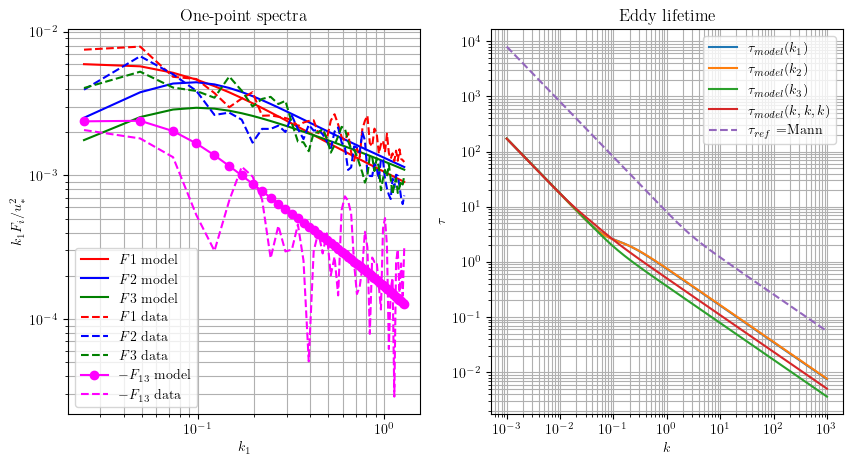

In [ ]:
opt_params = pb.calibrate(Data=Data, **config)

In [ ]:
X = [1, 2, 3, 4]

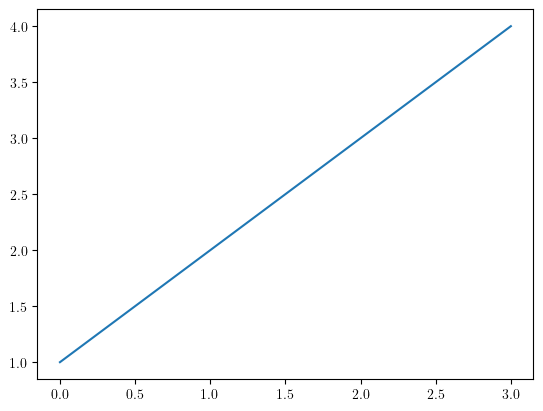

In [ ]:
plt.plot(X)

In [ ]:
plt.savefig(savedir)

<Figure size 640x480 with 0 Axes>